# Overall Workflow
## 1. The Dataset
## 2. Preprocessing Before Modeling
## 3. Model Validation & Performance Report
## 4. Feature Importance Report
## 5. Summary

# Packages

In [1]:
# Data structures
import numpy as np
import pandas as pd

# Data formats
import csv
import json

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use("ggplot")

# Statistical testings
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine learning algorithms
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb 
import lightgbm as lgb

# Model validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 1. The dataset

In [2]:
data = pd.read_csv('data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# After inspecting this column, it's an empty column.
data.drop(columns=['Unnamed: 32','id'], inplace = True)

In [4]:
# 569 data with 31 features.
data.shape

(569, 31)

# 2. Preprocessing Before Modeling
- **2.1 One-hot encoding - response**
- **2.2 Train & test splitting (80%/20%)**
- **2.3 Standardization**
    - Why standardization is needed? -> Regularization purpose.

## 2.1 One-hot encoding - response

In [5]:
data['diagnosis'].head()

0    M
1    M
2    M
3    M
4    M
Name: diagnosis, dtype: object

In [6]:
# One-hot encoding for categorical features containing two levels.
# The response variable, diagnosis, contains two levels, M and B.
le = LabelEncoder()
le.fit(data['diagnosis'])
data['diagnosis'] = le.transform(data['diagnosis'])
data['diagnosis'].head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [7]:
# Make sure the transformation is correct!
# 0: B (benign)
# 1: M (malignant)
data['diagnosis'].unique()

array([1, 0])

In [8]:
data['diagnosis'].value_counts() / data.shape[0]

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

## 2.2 Train & test splitting (80%, 20%)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data[data.columns.difference(['diagnosis'])], 
                                                    data.diagnosis, 
                                                    test_size=0.2, random_state=0) 

In [10]:
# Make sure the splitting is correct!
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(455, 30) (455,)
(114, 30) (114,)


In [11]:
# The label distribution in testing data is also closed to the original distribution.
print(sum(y_test == 0) / len(y_test))
print(sum(y_test == 1) / len(y_test))

0.5877192982456141
0.41228070175438597


## 2.3 Standardization

In [12]:
# Test data are unseen data! 
# Since my purpose is to build a prediction model, 
# I shouldn't contaminate train and test data together when standardizing them.  
std_scaler = StandardScaler().fit(x_train)

train_standardized_data = std_scaler.transform(x_train)
test_standardized_data = std_scaler.transform(x_test)

In [13]:
# Make sure the standardization is correct (mean must be 0 and variance must be 1).
pd.DataFrame(train_standardized_data).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,3.047623e-16,3.233067e-17,1.141944e-16,-1.165124e-17,1.988641e-17,-3.963414e-17,1.051052e-16,-2.722486e-16,7.002945e-17,-2.498612e-16,...,-4.540934e-16,-4.420152e-16,3.043963e-16,-1.862979e-16,-6.134287e-16,-1.395709e-16,5.290030e-16,9.604039e-16,1.708035e-16,4.924022e-16
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-1.426379e+00,-6.933525e-01,-1.188201e+00,-1.664312e+00,-1.304206e+00,-1.468356e+00,-1.262871e+00,-1.977069e+00,-1.754014e+00,-1.125696e+00,...,-1.704360e+00,-3.176344e+00,-1.862462e+00,-2.711807e+00,-2.738225e+00,-1.544220e+00,-2.128278e+00,-2.272988e+00,-1.569514e+00,-2.218398e+00
25%,-6.577342e-01,-4.728731e-01,-6.257607e-01,-7.367713e-01,-6.868424e-01,-6.807320e-01,-7.254573e-01,-6.714551e-01,-7.585201e-01,-7.403181e-01,...,-6.624319e-01,-7.082998e-01,-6.477273e-01,-7.105576e-01,-6.975035e-01,-6.730116e-01,-6.518526e-01,-7.420774e-01,-6.972753e-01,-7.439783e-01
50%,-3.131017e-01,-3.508041e-01,-3.516681e-01,-2.188714e-01,-2.751908e-01,-2.619431e-01,-3.963173e-01,-1.470704e-01,-2.427267e-01,-3.517235e-01,...,-2.878293e-01,-3.433938e-02,-2.233357e-01,-3.801757e-02,-6.354630e-02,-2.204915e-01,-1.416994e-01,-9.697672e-02,-1.530956e-01,-5.394673e-02
75%,3.009759e-01,8.650504e-02,2.583182e-01,5.151506e-01,3.805932e-01,5.435962e-01,6.589276e-01,5.005592e-01,7.103914e-01,4.775784e-01,...,4.409060e-01,6.519540e-01,4.057706e-01,5.659411e-01,5.320447e-01,2.943188e-01,4.542741e-01,5.866375e-01,4.841820e-01,6.229571e-01
max,5.163006e+00,1.052718e+01,5.758096e+00,4.125777e+00,6.308377e+00,5.270909e+00,3.955644e+00,6.984494e+00,2.695096e+00,4.366097e+00,...,4.049783e+00,3.503046e+00,5.747718e+00,3.988374e+00,4.496561e+00,4.999672e+00,5.934052e+00,3.528104e+00,6.788612e+00,3.938555e+00


# 3. Model Validation & Performance Report
- **3.1 Model validation: Five-folds Cross Validation**
    - 3.1.1 Logistic Regression
    - 3.1.2 SGDClassifier
    - 3.1.3 Decision Tree
    - 3.1.4 Bagging - Decision Tree
    - 3.1.5 Random Forest
    - 3.1.6 AdaBoost
    - 3.1.7 Gradient Boosting
    - 3.1.8 XGBoost
    - 3.1.9 LightGBM
- **3.2 Model performance report**
    - 3.2.1 Logistic Regression
    - 3.2.2 SGDClassifier
    - 3.2.3 Decision Tree
    - 3.2.4 Bagging - Decision Tree
    - 3.2.5 Random Forest
    - 3.2.6 AdaBoost
    - 3.2.7 Gradient Boosting
    - 3.2.8 XGBoost
    - 3.2.9 LightGBM
- **3.3 Model performance summary**

## 3.1 Model validation: Five-folds Cross Validation

### 3.1.1 Logistic Regression

In [14]:
pd.read_csv('Breast_Cancer_LR.csv').sort_values(by='loss').hyperparameters.head(1).values

array(["{'C': 0.6846710865887865, 'fit_intercept': True, 'penalty': 'l2', 'random_state': 0}"],
      dtype=object)

In [15]:
# Initiate the model and specify the optimal combination of hyperparameters.
lr_model = LogisticRegression(C=0.6846710865887865,
                              fit_intercept=True,
                              penalty='l2',
                              random_state=0)

# I chose 'roc_auc' as the model performance metric evaluation since it can let me balance
# between precision and recall metrics.
# The main objective of this project is to identify 'malignant' patients correctly such 
# that immediate treatment can be taken into consideration.
scores = cross_validate(lr_model, train_standardized_data, y_train, scoring='roc_auc',
                        cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

In [16]:
# From the five-folds cross validation result, the model (Logistic Regression) is 
# pretty steady observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9953.
The standard deviation is 0.0079 across five folds.
The average AUC score on train sets is 0.9974.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.2 SGDClassifier

In [17]:
pd.read_csv('Breast_Cancer_SGD.csv').sort_values(by='loss').hyperparameters.head(1).values

array(["{'alpha': 0.02099581102920922, 'fit_intercept': True, 'l1_ratio': 0.6350799636217396, 'loss': 'log', 'penalty': 'l2', 'random_state': 0}"],
      dtype=object)

In [18]:
sgd_model = SGDClassifier(loss='log',
                           alpha=0.02099581102920922,
                           fit_intercept=True,
                           l1_ratio=0.6350799636217396,
                           penalty='l2',
                           random_state=0)

scores = cross_validate(sgd_model, train_standardized_data, y_train, scoring='roc_auc',
                        cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both ar

In [19]:
# From the five-folds cross validation result, the model (SGDclassifier) is pretty steady
# observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9948.
The standard deviation is 0.0079 across five folds.
The average AUC score on train sets is 0.9961.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.3 Decision Tree

In [20]:
pd.read_csv('Breast_Cancer_DT.csv').sort_values(by='loss').hyperparameters.head(1).values

array(["{'criterion': 'entropy', 'max_depth': 448.2261637557397, 'min_samples_split': 0.08852350974712808, 'random_state': 0}"],
      dtype=object)

In [23]:
dt_model = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=448,
                                  min_samples_split=0.08852350974712808,
                                  random_state=0)

scores = cross_validate(dt_model, x_train, y_train, scoring='roc_auc',
                        cv=5)

In [24]:
# From the five-folds cross validation result, the model (Decision Tree) is unsteady
# compared with the above two models, Logistic Regression and SGDClassifier.
# Also, the difference of AUC scores between train and test data is larger than 
# previous models. 
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9577.
The standard deviation is 0.0183 across five folds.
The average AUC score on train sets is 0.9931.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.4 Bagging - Decision Tree

In [25]:
pd.read_csv('Breast_Cancer_Bag_DT.csv').sort_values(by='loss').hyperparameters.head(1).values

array(["{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,\n            max_features=None, max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, presort=False, random_state=0,\n            splitter='best'), 'bootstrap': True, 'max_samples': 0.5899786266134648, 'n_estimators': 144, 'random_state': 0}"],
      dtype=object)

In [26]:
base_learner = DecisionTreeClassifier(max_depth=15,random_state=0)

bag_dt_model = BaggingClassifier(base_estimator=base_learner,
                                 bootstrap=True,
                                 max_samples=0.5899786266134648,
                                 n_estimators=144,
                                 random_state=0,
                                 oob_score=True)

scores = cross_validate(bag_dt_model, x_train, y_train, scoring='roc_auc',
                        cv=5)

In [27]:
# From the five-folds cross validation result, the model (Bagging Decision Tree) is 
# pretty steady observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9904.
The standard deviation is 0.006 across five folds.
The average AUC score on train sets is 0.9999.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.5 Random Forest

In [29]:
pd.read_csv('Breast_Cancer_RF.csv').sort_values(by='loss').hyperparameters.head(1).values

array(["{'bootstrap': True, 'criterion': 'gini', 'max_depth': 204, 'max_features': 0.24677158354191386, 'min_samples_leaf': 0.005546201011225804, 'min_samples_split': 0.003664830699644849, 'n_estimators': 438, 'random_state': 0}"],
      dtype=object)

In [30]:
rf_model = RandomForestClassifier(criterion='gini',
                                  n_estimators=438,
                                  max_depth=204,
                                  max_features=0.24677158354191386,
                                  min_samples_leaf=0.005546201011225804,
                                  min_samples_split=0.003664830699644849,
                                  bootstrap=True,
                                  random_state=0
                                 )
                                 
scores = cross_validate(rf_model, x_train, y_train, scoring='roc_auc',
                        cv=5)

In [31]:
# From the five-folds cross validation result, the model (Random Forest) is pretty steady
# observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9898.
The standard deviation is 0.0073 across five folds.
The average AUC score on train sets is 0.9995.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.6 AdaBoost

In [32]:
pd.read_csv('Breast_Cancer_AdaBoost.csv').sort_values(by='loss').hyperparameters.head(1).values

array(["{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,\n            max_features=None, max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, presort=False, random_state=0,\n            splitter='best'), 'learning_rate': 0.9799208625897863, 'n_estimators': 243, 'random_state': 0}"],
      dtype=object)

In [33]:
base_learner = DecisionTreeClassifier(max_depth=4, random_state=0)

ada_boost_model = AdaBoostClassifier(base_estimator=base_learner,
                                     n_estimators=243,
                                     learning_rate=0.9799208625897863,
                                     random_state=0
                                    )

scores = cross_validate(ada_boost_model, x_train, y_train, scoring='roc_auc',
                        cv=5)

In [34]:
# From the five-folds cross validation result, the model (AdaBoost) is pretty steady
# observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9958.
The standard deviation is 0.0045 across five folds.
The average AUC score on train sets is 1.0.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.7 Gradient Boosting

In [35]:
pd.read_csv('Breast_Cancer_GradientBoost.csv').sort_values(by='loss').hyperparameters.head(1).values

array(["{'learning_rate': 0.08694975096042357, 'max_depth': 7.335097325163314, 'max_features': 0.15777626256292848, 'n_estimators': 61, 'random_state': 0, 'subsample': 0.7690071264063302}"],
      dtype=object)

In [36]:
gradient_boost_model = GradientBoostingClassifier(n_estimators=61,
                                                  max_depth=7,
                                                  max_features=0.15777626256292848,
                                                  subsample=0.7690071264063302,
                                                  learning_rate=0.08694975096042357,
                                                  random_state=0
                                                 )
                            
scores = cross_validate(gradient_boost_model, x_train, y_train, scoring='roc_auc',
                        cv=5)

In [37]:
# From the five-folds cross validation result, the model (Gradient Boosting) is 
# pretty steady observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9938.
The standard deviation is 0.0042 across five folds.
The average AUC score on train sets is 1.0.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.8 XGBoost

In [38]:
pd.read_csv('Breast_Cancer_XGB.csv').sort_values(by='loss').hyperparameters.head(1).values

array(["{'alpha': 0.4369943595381558, 'colsample_bylevel': 0.2905096078115737, 'colsample_bynode': 0.6300404451387125, 'colsample_bytree': 0.5550946683724962, 'eta': 0.3392632704567006, 'eval_metric': 'auc', 'lambda': 0.41081849491034733, 'max_depth': 5, 'num_round': 31, 'objective': 'binary:logistic', 'subsample': 0.5315661431503793, 'task': 'train'}"],
      dtype=object)

In [39]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              eval_metric='auc',
                              n_estimators=31,
                              max_depth=5,
                              eta=0.3392632704567006,
                              reg_alpha=0.4369943595381558,
                              reg_lambda=0.41081849491034733,
                              subsample=0.5315661431503793,
                              colsample_bylevel=0.2905096078115737,
                              colsample_bynode=0.6300404451387125,
                              colsample_bytree=0.5550946683724962)
    
scores = cross_validate(xgb_model, x_train, y_train, scoring='roc_auc',
                        cv=5)

In [40]:
# From the five-folds cross validation result, the model (XGBoost) is pretty steady
# observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9893.
The standard deviation is 0.0091 across five folds.
The average AUC score on train sets is 0.9977.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### 3.1.9 LightGBM

In [42]:
pd.read_csv('Breast_Cancer_LightGBM.csv').sort_values(by='loss')[::-1].hyperparameters.head(1).values

array(["{'bagging_fraction': 1.0, 'feature_fraction': 1.0, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'learning_rate': 1.0, 'max_depth': 4.700207596526207, 'num_iterations': 465.63538363064913}"],
      dtype=object)

In [43]:
lgb_model = lgb.LGBMClassifier(objective='binary',
                               random_state=0,
                               num_iterations=466,
                               bagging_fraction=1.0,
                               bagging_freq=1,
                               feature_fraction=1.0,
                               lambda_l1=0.0,
                               lambda_l2=0.0,
                               learning_rate=1.0,
                               max_depth=5)
                                                                                                                                                
# Five-folds cross validation
scores = cross_validate(lgb_model, x_train, y_train, 
                        scoring='roc_auc', cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/wuchenhon

In [44]:
# From the five-folds cross validation result, the model (LightGBM) is pretty steady
# observed from the standard deviation of five folds. 
# The AUC scores are close between train and test data.
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.9907.
The standard deviation is 0.0078 across five folds.
The average AUC score on train sets is 1.0.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## 3.2 Model performance report

In [45]:
# Helper function of printing metric scores.   
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                           accuracy_score(y_train, y_train_pred>threshold),
                           precision_score(y_train, y_train_pred>threshold),
                           recall_score(y_train, y_train_pred>threshold),
                           f1_score(y_train, y_train_pred>threshold)
                          ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                          accuracy_score(y_test, y_test_pred>threshold),
                          precision_score(y_test, y_test_pred>threshold),
                          recall_score(y_test, y_test_pred>threshold),
                          f1_score(y_test, y_test_pred>threshold)
                         ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},
                               columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [46]:
# Helper function of plotting the roc curve of a model.
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [47]:
# Helper function of plotting different scores given differnt threshold values.
def threshold_metric_visualization(y_test, prediction):
    # Storing scores
    accuracy_score_ls = []
    precision_score_ls = []
    recall_score_ls = []
    f1_score_ls = []
    threshold_ls = []
    predictions = prediction
    
    # Loop through different thresholds ranged from 0 to 1.
    for threshold in np.arange(0, 1, 0.1):
        threshold_ls.append(threshold)
        accuracy_score_ls.append(accuracy_score(y_test, predictions>threshold))
        precision_score_ls.append(precision_score(y_test, predictions>threshold))
        recall_score_ls.append(recall_score(y_test, predictions>threshold))
        f1_score_ls.append(f1_score(y_test, predictions>threshold))
    
    # Visualizations
    plt.figure(figsize=(10,6))
    plt.plot(threshold_ls,accuracy_score_ls)
    plt.plot(threshold_ls,precision_score_ls)
    plt.plot(threshold_ls,recall_score_ls)
    plt.plot(threshold_ls,f1_score_ls)
    plt.legend(['accuracy', 'precision', 'recall', 'f1-score'], loc = 'best')
    plt.xlabel('threshold')
    plt.ylabel('score')

### 3.2.1 Logistic Regression

In [48]:
lr_model.fit(X=train_standardized_data, y=y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.6846710865887865, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

              train      test
metrics                      
AUC        0.997179  0.993649
Accuracy   0.989011  0.964912
Precision  0.993827  0.957447
Recall     0.975758  0.957447
f1-score   0.984709  0.957447


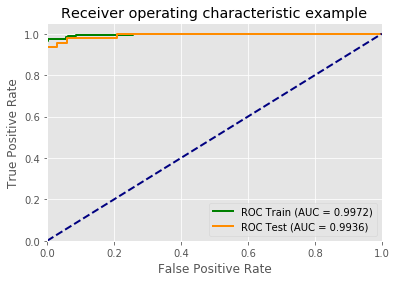

In [49]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
get_performance_metrics(y_train=y_train, 
                        y_train_pred=lr_model.predict_proba(train_standardized_data)[:,1], 
                        y_test=y_test, 
                        y_test_pred=lr_model.predict_proba(test_standardized_data)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=lr_model.predict_proba(train_standardized_data)[:, 1], 
               y_test=y_test, 
               y_test_pred=lr_model.predict_proba(test_standardized_data)[:,1])

In [50]:
print(classification_report(y_true=y_test, 
                            y_pred=lr_model.predict(test_standardized_data)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        67
           1       0.96      0.96      0.96        47

   micro avg       0.96      0.96      0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



In [51]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                             y_pred=lr_model.predict(test_standardized_data)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,65,2
True 1,2,45


### 3.2.2 SGDClassifier

In [52]:
sgd_model.fit(X=train_standardized_data, y=y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.02099581102920922, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.6350799636217396, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

              train      test
metrics                      
AUC        0.995674  0.995237
Accuracy   0.982418  0.964912
Precision  0.993711  0.977778
Recall     0.957576  0.936170
f1-score   0.975309  0.956522


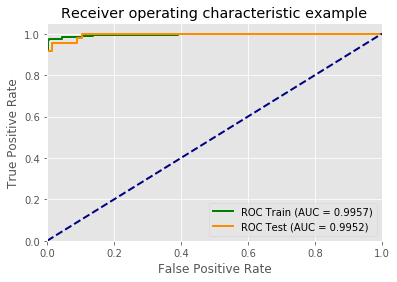

In [53]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
get_performance_metrics(y_train=y_train, 
                        y_train_pred=sgd_model.predict_proba(train_standardized_data)[:,1], 
                        y_test=y_test, 
                        y_test_pred=sgd_model.predict_proba(test_standardized_data)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=sgd_model.predict_proba(train_standardized_data)[:, 1], 
               y_test=y_test, 
               y_test_pred=sgd_model.predict_proba(test_standardized_data)[:,1])

In [54]:
print(classification_report(y_true=y_test, 
                            y_pred=sgd_model.predict(test_standardized_data)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        67
           1       0.98      0.94      0.96        47

   micro avg       0.96      0.96      0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [55]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                             y_pred=sgd_model.predict(test_standardized_data)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,66,1
True 1,3,44


### 3.2.3 Decision Tree

In [56]:
dt_model.fit(X=x_train, y=y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=448,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.08852350974712808,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

              train      test
metrics                      
AUC        0.988495  0.973960
Accuracy   0.936264  0.921053
Precision  0.861702  0.851852
Recall     0.981818  0.978723
f1-score   0.917847  0.910891


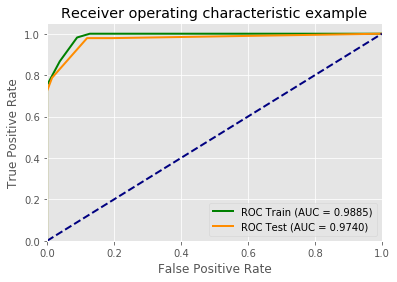

In [57]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
get_performance_metrics(y_train=y_train, 
                        y_train_pred=dt_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=dt_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=dt_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=dt_model.predict_proba(x_test)[:,1])

In [58]:
print(classification_report(y_true=y_test, 
                            y_pred=dt_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93        67
           1       0.85      0.98      0.91        47

   micro avg       0.92      0.92      0.92       114
   macro avg       0.92      0.93      0.92       114
weighted avg       0.93      0.92      0.92       114



In [59]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                             y_pred=dt_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,59,8
True 1,1,46


## 3.2.4 Bagging - Decision Tree

In [60]:
bag_dt_model.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.5899786266134648, n_estimators=144, n_jobs=None,
         oob_score=True, random_state=0, verbose=0, warm_start=False)

              train      test
metrics                      
AUC        0.999885  0.995554
Accuracy   0.995604  0.956140
Precision  1.000000  0.937500
Recall     0.987879  0.957447
f1-score   0.993902  0.947368


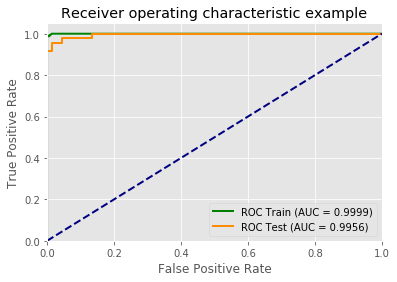

In [61]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
get_performance_metrics(y_train=y_train, 
                        y_train_pred=bag_dt_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=bag_dt_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=bag_dt_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=bag_dt_model.predict_proba(x_test)[:,1])

In [62]:
print(classification_report(y_true=y_test, 
                            y_pred=bag_dt_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        67
           1       0.94      0.96      0.95        47

   micro avg       0.96      0.96      0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [63]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                             y_pred=bag_dt_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,64,3
True 1,2,45


### 3.2.5 Random Forest

In [64]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=204, max_features=0.24677158354191386,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.005546201011225804,
            min_samples_split=0.003664830699644849,
            min_weight_fraction_leaf=0.0, n_estimators=438, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

              train      test
metrics                      
AUC        0.999582  0.996507
Accuracy   0.991209  0.973684
Precision  1.000000  0.958333
Recall     0.975758  0.978723
f1-score   0.987730  0.968421


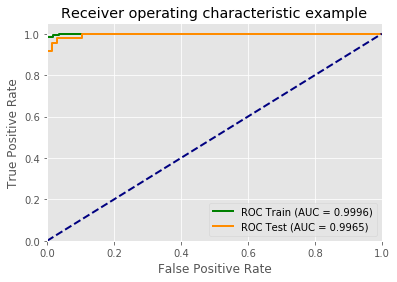

In [65]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
get_performance_metrics(y_train=y_train, 
                        y_train_pred=rf_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=rf_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=rf_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=rf_model.predict_proba(x_test)[:,1])

In [66]:
print(classification_report(y_true=y_test, 
                            y_pred=rf_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98        67
           1       0.96      0.98      0.97        47

   micro avg       0.97      0.97      0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [67]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                             y_pred=rf_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,65,2
True 1,1,46


### 3.2.6 AdaBoost

In [68]:
ada_boost_model.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=0.9799208625897863, n_estimators=243,
          random_state=0)

           train      test
metrics                   
AUC          1.0  0.996189
Accuracy     1.0  0.947368
Precision    1.0  0.936170
Recall       1.0  0.936170
f1-score     1.0  0.936170


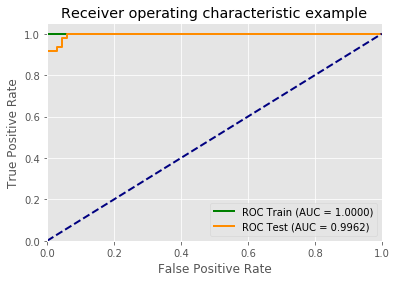

In [69]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
get_performance_metrics(y_train=y_train, 
                        y_train_pred=ada_boost_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=ada_boost_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=ada_boost_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=ada_boost_model.predict_proba(x_test)[:,1])

In [70]:
print(classification_report(y_true=y_test, 
                            y_pred=ada_boost_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        67
           1       0.94      0.94      0.94        47

   micro avg       0.95      0.95      0.95       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114



In [71]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                             y_pred=ada_boost_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,64,3
True 1,3,44


### 3.2.7 Gradient Boosting

In [72]:
gradient_boost_model.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08694975096042357, loss='deviance',
              max_depth=7, max_features=0.15777626256292848,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=61, n_iter_no_change=None, presort='auto',
              random_state=0, subsample=0.7690071264063302, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

           train      test
metrics                   
AUC          1.0  0.997142
Accuracy     1.0  0.964912
Precision    1.0  0.938776
Recall       1.0  0.978723
f1-score     1.0  0.958333


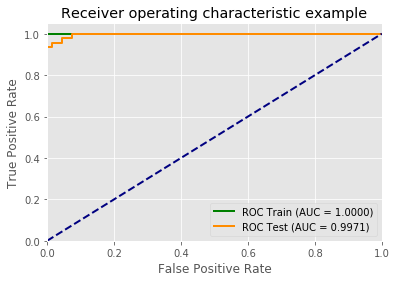

In [73]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
get_performance_metrics(y_train=y_train, 
                        y_train_pred=gradient_boost_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=gradient_boost_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=gradient_boost_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=gradient_boost_model.predict_proba(x_test)[:,1])

In [74]:
print(classification_report(y_true=y_test, 
                            y_pred=gradient_boost_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        67
           1       0.94      0.98      0.96        47

   micro avg       0.96      0.96      0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



In [75]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                             y_pred=gradient_boost_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,64,3
True 1,1,46


### 3.2.8 XGBoost

In [77]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.2905096078115737,
       colsample_bynode=0.6300404451387125,
       colsample_bytree=0.5550946683724962, eta=0.3392632704567006,
       eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=31,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4369943595381558, reg_lambda=0.41081849491034733,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5315661431503793)

              train      test
metrics                      
AUC        0.998140  0.995237
Accuracy   0.984615  0.964912
Precision  0.993750  0.957447
Recall     0.963636  0.957447
f1-score   0.978462  0.957447


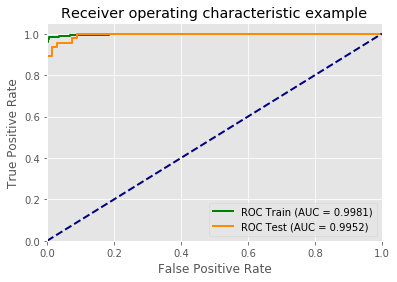

In [78]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 8
get_performance_metrics(y_train=y_train, 
                        y_train_pred=xgb_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=xgb_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=xgb_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=xgb_model.predict_proba(x_test)[:,1])

In [79]:
print(classification_report(y_true=y_test, 
                            y_pred=xgb_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        67
           1       0.96      0.96      0.96        47

   micro avg       0.96      0.96      0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



In [80]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                             y_pred=xgb_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,65,2
True 1,2,45


### 3.2.9 LightGBM

In [81]:
lgb_model.fit(x_train, y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=1.0, bagging_freq=1, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
        importance_type='split', lambda_l1=0.0, lambda_l2=0.0,
        learning_rate=1.0, max_depth=5, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_iterations=466, num_leaves=31, objective='binary',
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

           train      test
metrics                   
AUC          1.0  0.998730
Accuracy     1.0  0.973684
Precision    1.0  0.978261
Recall       1.0  0.957447
f1-score     1.0  0.967742


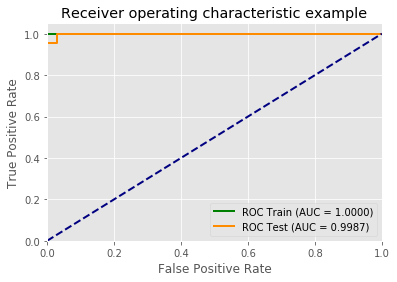

In [82]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 9
get_performance_metrics(y_train=y_train, 
                        y_train_pred=lgb_model.predict_proba(x_train)[:,1], 
                        y_test=y_test, 
                        y_test_pred=lgb_model.predict_proba(x_test)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=lgb_model.predict_proba(x_train)[:, 1], 
               y_test=y_test, 
               y_test_pred=lgb_model.predict_proba(x_test)[:,1])

In [83]:
# Model 9 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=lgb_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        67
           1       0.98      0.96      0.97        47

   micro avg       0.97      0.97      0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [84]:
# Model 9 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=lgb_model.predict(x_test)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,66,1
True 1,2,45


## 3.3 Model performance summary
- I ranked all nine models based on the metric, AUC (area under the curve), since AUC provides me a flexibility to choose between precision and f1-score. 
- The hospital might treat 'malignant' patients more important than 'benign' patients because diagnosing patients correctly when they really have 'malignant' cells is extremely critical!
- A higher precision indicates that over all the positive predictions or over the patients have been predicted as malignant, how many of them have been correctly predicted as the true malignant patients.
- A higher recall means that over all the true malignant patients, how many of them have been correctly predicted as malignant.
- Three of boosting models including LightGBM, Gradient Boosting, and AdaBoost are ranked in the top. Random Forest ranked 3 is somehow surprised me because boosting trees usually outperform than bagging models (Random Forest is considered as one of bagging models). However, the AUC score difference between Random Forest and AdaBoost is extremely close to each other. Boosting trees are relatively steady in this dataset but should be noticed that overfitting issue must be addressed by including and regulating hyperparamters that could avoid the issue. Lastly, the performance difference between linear and non-linear models is very close, indicating that there are some linear relationship existed between predictors and the response variable. Thus, whatever the linear or non-linear models I chose, they can both capture this relationship.

| Model | AUC score on test data | Rank | std of five folds | auc score difference between train and test |
| -- | -- | -- | -- | -- |
| LightGBM | 0.9987  | 1 | 0.0078 | 0.0013 (2)
| Gradient Boosting | 0.9971 | 2 | 0.0042 (1) | 0.0029 (3)
| Random Forest | 0.9965 | 3 | 0.0073 | 0.0031 
| AdaBoost | 0.9962 | 4 | 0.0045 (2) | 0.0038
| Bagging - Decision Tree | 0.9956 | 5 | 0.006 (3) | 0.0043
| XGBoost | 0.9952 | 6 | 0.0091 | 0.0029 (3)
| SGDClassifier | 0.9952 | 6 | 0.0079 | 0.0005 (1)
| Logistic Regression | 0.9936 | 8 | 0.0079 | 0.0036
| Decision Tree | 0.9740 | 9 | 0.0183 | 0.0145

# 4. Feature Importance Report
- **4.1 Less important features**
    - 4.1.1 SGDClassifier
    - 4.1.2 LightGBM
    - 4.1.3 Gradient Boosting
    - 4.1.4 Random Forest
    - 4.1.5 Adaboost
- **4.2 The top 10 important features**
    - 4.2.1 SGDClassifier
    - 4.2.2 LightGBM
    - 4.2.3 Gradient Boosting
    - 4.2.4 Random Forest
    - 4.2.5 Adaboost
- **4.3 Comparison: Top 10 predictors**

## 4.1 Less important features
- If the coefficient of a predictor has been pushed to 0, then this predictor doesn't play any significant role in predictions.

### 4.1.1 SGDClassifier
- Since the Logistic function (sigmoid function) in the Logistic Regression is still a linear relationship between the feature and the response, I chose SGDClassifier, an efficient type of Logistic Regression and a linear model, to inspect the feature coefficients. I didn't choose the Logistic Regression for the demonstration because of a lower AUC (area under the curve) score achieved on the test data.

In [85]:
i = 0
for index in abs(sgd_model.coef_.flatten()).argsort():
    if sgd_model.coef_.flatten()[index] == 0:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(sgd_model.coef_.flatten()[index], 4)
             ))
        i+=1
print('{} coefficients of predictors were pushed to 0.'.format(i))

0 coefficients of predictors were pushed to 0.


In [102]:
# From the least to the most important predictors
x_train.columns[np.argsort(sgd_model.coef_.flatten())]

Index(['fractal_dimension_se', 'fractal_dimension_mean', 'compactness_se',
       'concavity_se', 'symmetry_se', 'smoothness_se', 'texture_se',
       'concave points_se', 'compactness_mean', 'smoothness_mean',
       'symmetry_mean', 'fractal_dimension_worst', 'compactness_worst',
       'perimeter_mean', 'symmetry_worst', 'radius_mean', 'smoothness_worst',
       'concavity_mean', 'texture_mean', 'area_mean', 'concavity_worst',
       'concave points_mean', 'perimeter_worst', 'perimeter_se', 'area_worst',
       'radius_worst', 'area_se', 'concave points_worst', 'texture_worst',
       'radius_se'],
      dtype='object')

### 4.1.2 LightGBM
- Contrast to the Logistic Regression, tree-based models such as Random Forest and Boosting trees produce a feature importance rank list but without the linear relationship existed because tree-based models learn the pattern between predictors and the response as a 'non-linear' function.

In [87]:
# Only one predictor has no contribution on the response variable.
pd.DataFrame(lgb_model.feature_importances_[lgb_model.feature_importances_ == 0],
             index = x_train.columns[lgb_model.feature_importances_ == 0],
             columns=['importance by xgboost'])

,importance by xgboost
fractal_dimension_mean,0


### 4.1.3 Gradient Boosting

In [88]:
# No predictors have no contribution on the response variable.
pd.DataFrame(gradient_boost_model.feature_importances_[gradient_boost_model.feature_importances_ == 0],
             index = x_train.columns[gradient_boost_model.feature_importances_ == 0],
             columns=['importance by Gradient Boosting'])

,importance by Gradient Boosting


### 4.1.4 Random Forest

In [89]:
# No predictors have no contribution on the response variable.
pd.DataFrame(rf_model.feature_importances_[rf_model.feature_importances_ == 0],
             index = x_train.columns[rf_model.feature_importances_ == 0],
             columns=['importance by Random Forest'])

,importance by Random Forest


### 4.1.5 Adaboost

In [90]:
# No predictors have no contribution on the response variable.
pd.DataFrame(ada_boost_model.feature_importances_[ada_boost_model.feature_importances_ == 0],
             index = x_train.columns[ada_boost_model.feature_importances_ == 0],
             columns=['importance by AdaBoost'])

,importance by AdaBoost


## 4.2 The top 10  important features

### 4.2.1 SGDClassifier

In [103]:
# The top 5 important negative predictors.
i = 0
for index in sgd_model.coef_.flatten().argsort():
    if sgd_model.coef_.flatten()[index] != 0 and i<5:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(sgd_model.coef_.flatten()[index], 4)),
             np.exp(sgd_model.coef_.flatten()[index]))
        i+=1

Coefficient of column fractal_dimension_se is -0.3381. 0.7131403855020827
Coefficient of column fractal_dimension_mean is -0.1876. 0.828938480406815
Coefficient of column compactness_se is -0.1667. 0.846493812902986
Coefficient of column concavity_se is -0.1427. 0.8670358367937789
Coefficient of column symmetry_se is -0.0978. 0.9068382905756395


In [104]:
# The top 5 important positive predictors.
i = 0
for index in sgd_model.coef_.flatten().argsort()[::-1]:
    if sgd_model.coef_.flatten()[index] != 0 and i<5:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(sgd_model.coef_.flatten()[index], 4)),
             np.exp(sgd_model.coef_.flatten()[index]))
        i+=1

Coefficient of column radius_se is 0.5583. 1.7476683313594223
Coefficient of column texture_worst is 0.5219. 1.6851996364781716
Coefficient of column concave points_worst is 0.5145. 1.6727194092719524
Coefficient of column area_se is 0.5019. 1.6518302761012225
Coefficient of column radius_worst is 0.4898. 1.63202337448172


In [122]:
# For all predictors.
for index in sgd_model.coef_.flatten().argsort()[::-1]:
    if sgd_model.coef_.flatten()[index] != 0:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(sgd_model.coef_.flatten()[index], 4)),
             np.exp(sgd_model.coef_.flatten()[index]))

Coefficient of column radius_se is 0.5583. 1.7476683313594223
Coefficient of column texture_worst is 0.5219. 1.6851996364781716
Coefficient of column concave points_worst is 0.5145. 1.6727194092719524
Coefficient of column area_se is 0.5019. 1.6518302761012225
Coefficient of column radius_worst is 0.4898. 1.63202337448172
Coefficient of column area_worst is 0.4859. 1.6256137316492985
Coefficient of column perimeter_se is 0.4766. 1.6105645809027749
Coefficient of column perimeter_worst is 0.4588. 1.5820995858334663
Coefficient of column concave points_mean is 0.4345. 1.5441923925518541
Coefficient of column concavity_worst is 0.4238. 1.527824106196335
Coefficient of column area_mean is 0.3827. 1.4661671147798554
Coefficient of column texture_mean is 0.3605. 1.4340341551334959
Coefficient of column concavity_mean is 0.3602. 1.4336304523580359
Coefficient of column smoothness_worst is 0.3545. 1.4254151236235173
Coefficient of column radius_mean is 0.3472. 1.41507646207119
Coefficient of c

#### Increasing the feature value by 1 decreases logit odds by theta and odds by the exponential of theta.

| Negative Feature |$$\theta$$| $$e^\theta$$ |
| - | - | - |
| fractal_dimension_se | -0.3381 | 0.7131 |
| fractal_dimension_mean | -0.1876 | 0.8289 |
| compactness_se | -0.1667 | 0.8465 | 
| contact | -0.1427 | 0.8670 | 
| month_jun | -0.0978 | 0.9068 |

#### Increasing the feature value by 1 increases logit odds by theta and odds by the exponential of theta.

| Positive Feature |$$\theta$$| $$e^\theta$$ |
| - | - | - |
| radius_se | 0.5583 | 1.7477 |
| texture_worst | 0.5219 | 1.6852 |
| concave points_worst | 0.5145 | 1.6727 | 
| area_se | 0.5019 | 1.6518 | 
| radius_worst | 0.4898 | 1.6320 |

### 4.2.2 LightGBM

In [105]:
# Top 10 important features by LightGBM.
lgbm_top_ten_f = pd.DataFrame({'importance': lgb_model.feature_importances_,
                               '% importance': lgb_model.feature_importances_/sum(lgb_model.feature_importances_)},
                              index = x_train.columns).sort_values('importance',ascending=False).head(10)
lgbm_top_ten_f

,importance,% importance
texture_worst,23,0.099138
texture_mean,18,0.077586
area_worst,14,0.060345
compactness_se,14,0.060345
concavity_worst,12,0.051724
texture_se,12,0.051724
area_se,12,0.051724
smoothness_worst,11,0.047414
concave points_worst,11,0.047414
symmetry_worst,10,0.043103


### 4.2.3 Gradient Boosting

In [106]:
# Top 10 important features by Gradient Boosting.
gb_top_ten_f = pd.DataFrame(gradient_boost_model.feature_importances_,
                            index = x_train.columns,
                            columns=['importance']).sort_values('importance',ascending=False).head(10)
gb_top_ten_f

,importance
area_worst,0.162263
perimeter_mean,0.137631
area_mean,0.090247
concave points_mean,0.081637
concavity_worst,0.076589
radius_worst,0.064461
perimeter_worst,0.055159
compactness_worst,0.034202
radius_mean,0.033640
area_se,0.033033


### 4.2.4 Random Forest

In [107]:
# Top 10 important features by Random Forest.
rf_top_ten_f = pd.DataFrame(rf_model.feature_importances_,
                            index = x_train.columns,
                            columns=['importance']).sort_values('importance',ascending=False).head(10)
rf_top_ten_f

,importance
perimeter_worst,0.179899
concave points_mean,0.146752
concave points_worst,0.133675
radius_worst,0.124954
area_worst,0.103093
concavity_mean,0.041652
perimeter_mean,0.040933
radius_mean,0.035508
area_se,0.030198
concavity_worst,0.027752


### 4.2.4 AdaBoost

In [108]:
# Top 10 important features by AdaBoost.
adaboost_top_ten_f = pd.DataFrame(ada_boost_model.feature_importances_,
                            index = x_train.columns,
                            columns=['importance']).sort_values('importance',ascending=False).head(10)
adaboost_top_ten_f

,importance
texture_worst,0.091581
texture_mean,0.067557
fractal_dimension_se,0.066259
concave points_mean,0.052501
area_se,0.051187
concavity_worst,0.044505
symmetry_mean,0.042856
fractal_dimension_mean,0.042464
perimeter_worst,0.042431
area_worst,0.040786


#### Summary

Text(0.5, 1.0, 'AdaBoost, AUC: 0.9962(4)')

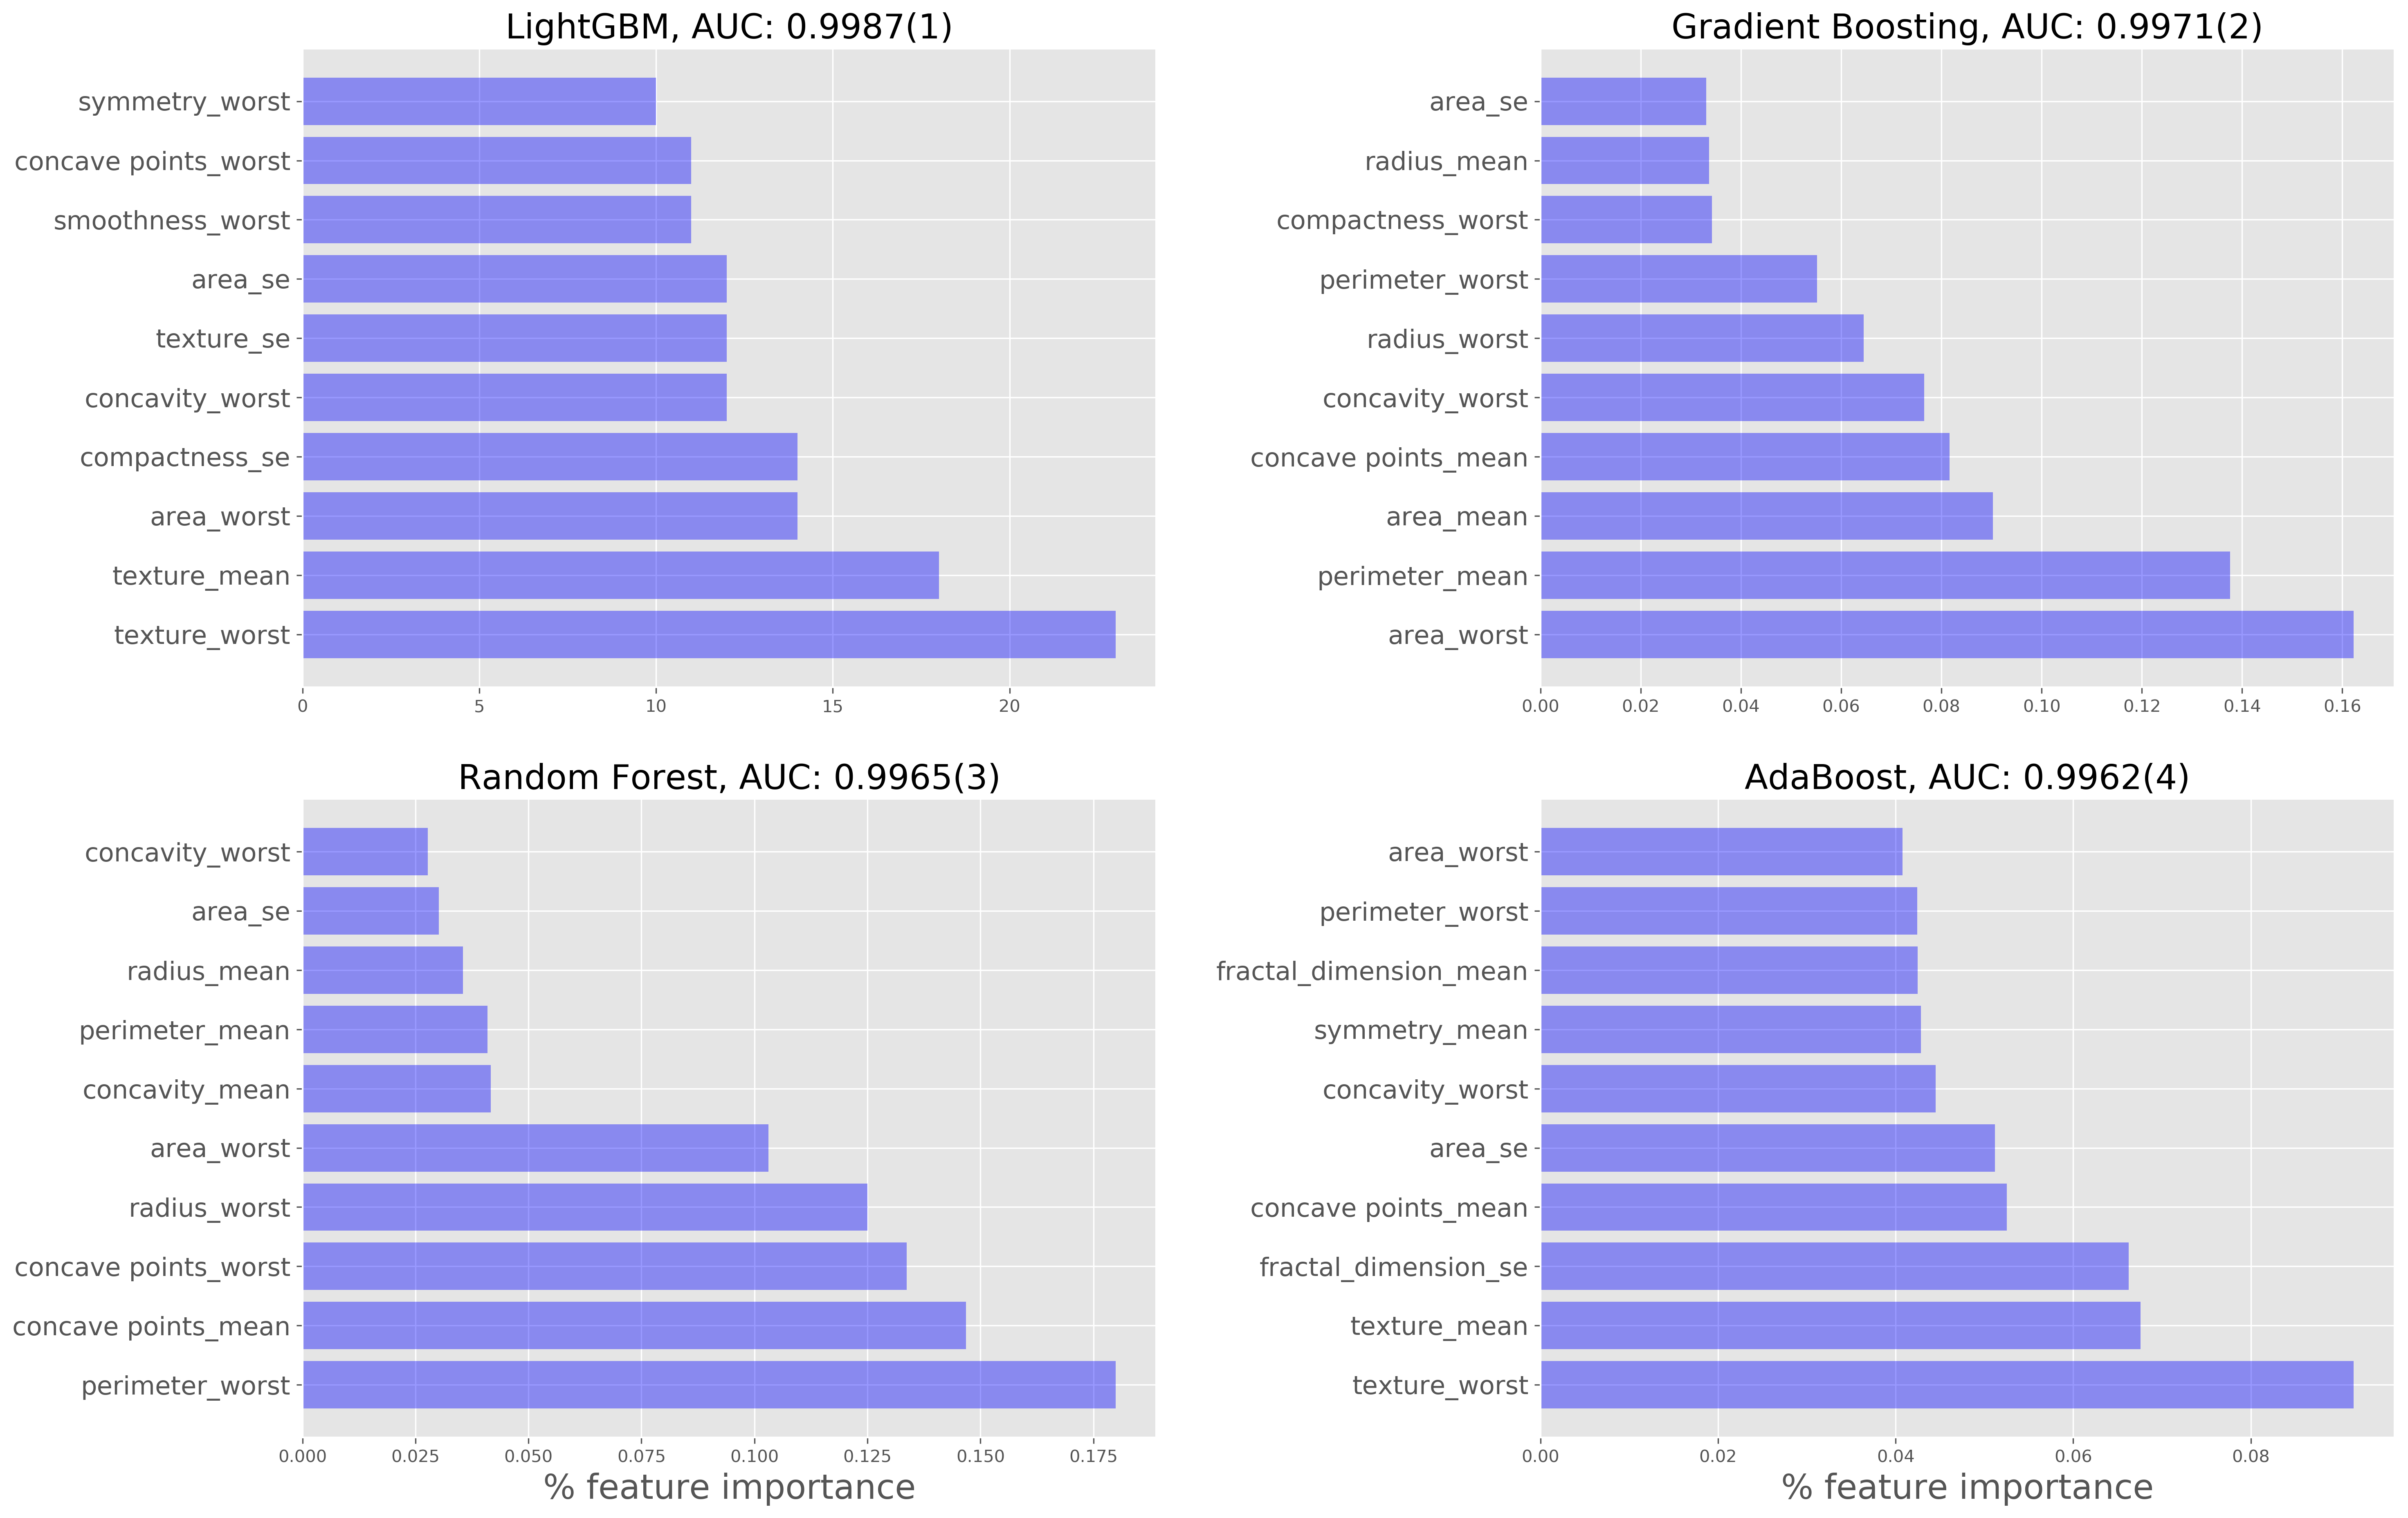

In [113]:
fig = plt.figure(figsize=(22,15), dpi=300)
fig.subplots_adjust(hspace=0.175, wspace=0.45)

plt.subplot(221)
plt.barh(np.arange(10), lgbm_top_ten_f['importance'].values, align='center', alpha=0.4, color='blue')
plt.yticks(np.arange(10), lgbm_top_ten_f.index, fontsize=15)
plt.title('LightGBM, AUC: 0.9987(1)',fontsize=20)
    
plt.subplot(222)
plt.barh(np.arange(10), gb_top_ten_f['importance'].values, align='center', alpha=0.4, color='blue')
plt.yticks(np.arange(10), gb_top_ten_f.index, fontsize=15)
plt.title('Gradient Boosting, AUC: 0.9971(2)',fontsize=20)

plt.subplot(223)
plt.barh(np.arange(10), rf_top_ten_f['importance'].values, align='center', alpha=0.4, color='blue')
plt.yticks(np.arange(10), rf_top_ten_f.index, fontsize=15)
plt.xlabel('% feature importance',fontsize=20)
plt.title('Random Forest, AUC: 0.9965(3)',fontsize=20)

plt.subplot(224)
plt.barh(np.arange(10), adaboost_top_ten_f['importance'].values, align='center', alpha=0.4, color='blue')
plt.yticks(np.arange(10), adaboost_top_ten_f.index, fontsize=15)
plt.xlabel('% feature importance',fontsize=20)
plt.title('AdaBoost, AUC: 0.9962(4)',fontsize=20)

In [114]:
# Append top 10 features provided by each model into a list.
top_ten_f = []
for each in lgbm_top_ten_f.index.values:
    top_ten_f.append(each)
for each in gb_top_ten_f.index.values:
    top_ten_f.append(each)
for each in rf_top_ten_f.index.values:
    top_ten_f.append(each)
for each in adaboost_top_ten_f.index.values:
    top_ten_f.append(each) 

In [115]:
# 40 features provided by 4 models.
len(top_ten_f)

40

In [116]:
# Majority vote: if a feature was ranked in the top 10 list four times, 
# then it is a very important feature!
dic_top_ten_f = {}
for each in top_ten_f:
    if each not in dic_top_ten_f:
        dic_top_ten_f[each] = 1
    else:
        dic_top_ten_f[each] += 1

In [117]:
# Sorted by the values.
for key, value in sorted(dic_top_ten_f.items(), key=lambda x: x[1], reverse=True):
    print("%s: %s" % (key, value))

area_worst: 4
concavity_worst: 4
area_se: 4
concave points_mean: 3
perimeter_worst: 3
texture_worst: 2
texture_mean: 2
concave points_worst: 2
perimeter_mean: 2
radius_worst: 2
radius_mean: 2
compactness_se: 1
texture_se: 1
smoothness_worst: 1
symmetry_worst: 1
area_mean: 1
compactness_worst: 1
concavity_mean: 1
fractal_dimension_se: 1
symmetry_mean: 1
fractal_dimension_mean: 1


## 4.3 Comparison: Top 10  predictors
- **'symmetry_se', 'texture_se', 'fractal_dimension_mean', and 'smoothness_se'** didn't pass the two sample t-test because their p-values are larger than 0.05. However, **'texture_se'** and **'fractal_dimension_mean'** has been included in the feature importance top 10 list. Both has been voted by one of the four models. 
- **fractal_dimension_se** passed the test, but notice that the p-value is very close to 0.05. **'fractal_dimension_se'** has been voted by one of the four models.
- **concave points_worst might be the most important predictor among all features observed from the test result.**  It has been voted by two of the four models.
  
| Column name | Rank (by two-sample t-test) | Number of votes (by top four models) | Rank (by SGDClassifier) | $$e^\theta$$ (or Odds, by SGDClassifier) |  
| -- | -- | -- | -- | -- |
| concave points_worst | 1 | 2 | 3 (positive) | 1.6727 |
| perimeter_worst | 2 | **3** | 8 (positive) | 1.5820 |
| concave points_mean | 3 | **3** | 9 (positive) | 1.5442 | 
| radius_worst | 4 | 2 | 5 (positive) | 1.6320 | 
| perimeter_mean | 5 | 2 | 17 (positive) | 1.4108 | 
| radius_mean | 6 | 2 | 15 (positive) | 1.4151 | 
| area_worst | 7 | **4** |  6 (positive) | 1.6256 | 
| concavity_mean | 8 | 1 | 13 (positive) | 1.4336 | 
| area_mean | 9 | 1 | 11 (positive) | 1.4662 | 
| concavity_worst | 10 | **4** | 10 (positive) | 1.5278 | 

# 5. Summary

## concave points_worst
- Description: "worst" or largest mean value for number of concave portions of the contour.
- Above the median value of feature 'concave points_worst', higher proportion of patients diagnosed as 'malignant' (71% vs 3%). The corresponding odds ratio is 1.6727, indicating that by increasing the value of concave points_worst by one, the odds being diagnosed as 'malignant' would be 1.6727 (odds: diagnosed as 'malignant' / diagnosed as 'benign').

In [120]:
# Find the median value.
# I pick the median value as the boundary line to distinguish patients.
data['concave points_worst'].describe()

count    569.000000
mean       0.114606
std        0.065732
min        0.000000
25%        0.064930
50%        0.099930
75%        0.161400
max        0.291000
Name: concave points_worst, dtype: float64

In [121]:
print(data[data['concave points_worst'] > 0.099930]['diagnosis'].value_counts() / 
      sum(data[data['concave points_worst'] > 0.099930]['diagnosis'].value_counts()))

print(data[data['concave points_worst'] <= 0.099930]['diagnosis'].value_counts() / 
      sum(data[data['concave points_worst'] <= 0.099930]['diagnosis'].value_counts()))

1    0.714789
0    0.285211
Name: diagnosis, dtype: float64
0    0.968421
1    0.031579
Name: diagnosis, dtype: float64


Text(0.5, 1.0, 'Distribution of concave points_worst')

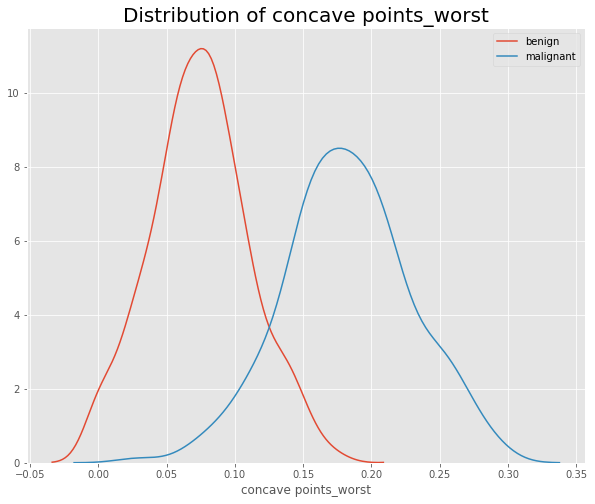

In [119]:
# Visualization
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 0, 'concave points_worst'], label = 'benign')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 1, 'concave points_worst'], label = 'malignant')

# Labeling
plt.xlabel('concave points_worst')
plt.title('Distribution of '+ 'concave points_worst', fontsize=20)

## perimeter_worst
- Description: Not provided by the dataset. In my perspective, it might be the length of the outer edge of a tumor, or "worst" or largest mean value for mean of the perimeter.
- Above the median value of feature 'perimeter_worst', higher proportion of patients diagnosed as 'malignant' (72% vs 2%). The corresponding odds ratio is 1.5820, indicating that by increasing the value of perimeter_worst by one, the odds being diagnosed as 'malignant' would be 1.5820 (odds: diagnosed as 'malignant' / diagnosed as 'benign').

In [126]:
data['perimeter_worst'].describe()

count    569.000000
mean     107.261213
std       33.602542
min       50.410000
25%       84.110000
50%       97.660000
75%      125.400000
max      251.200000
Name: perimeter_worst, dtype: float64

In [127]:
print(data[data['perimeter_worst'] > 97.66]['diagnosis'].value_counts() / 
      sum(data[data['perimeter_worst'] > 97.66]['diagnosis'].value_counts()))

print(data[data['perimeter_worst'] <= 97.66]['diagnosis'].value_counts() / 
      sum(data[data['perimeter_worst'] <= 97.66]['diagnosis'].value_counts()))

1    0.721831
0    0.278169
Name: diagnosis, dtype: float64
0    0.975439
1    0.024561
Name: diagnosis, dtype: float64


Text(0.5, 1.0, 'Distribution of perimeter_worst')

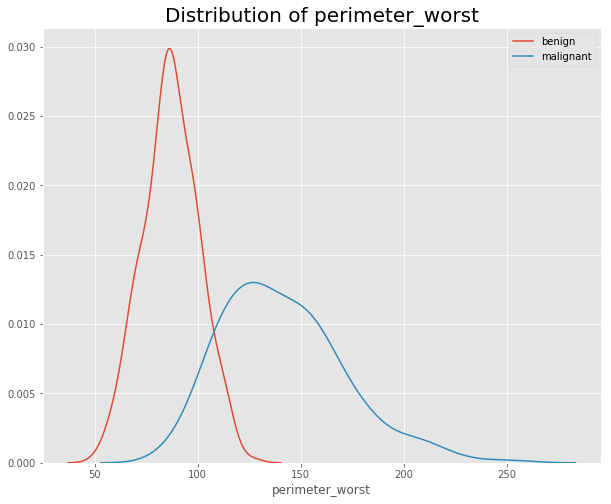

In [128]:
# Visualization
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 0, 'perimeter_worst'], label = 'benign')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 1, 'perimeter_worst'], label = 'malignant')

# Labeling
plt.xlabel('perimeter_worst')
plt.title('Distribution of '+ 'perimeter_worst', fontsize=20)

## concave points_mean
- Description: mean for number of concave portions of the contour.
- Above the median value of feature 'concave points_mean', higher proportion of patients diagnosed as 'malignant' (71% vs 4%). The corresponding odds ratio is 1.5442, indicating that by increasing the value of concave points_mean by one, the odds being diagnosed as 'malignant' would be 1.5442 (odds: diagnosed as 'malignant' / diagnosed as 'benign').

In [129]:
data['concave points_mean'].describe()

count    569.000000
mean       0.048919
std        0.038803
min        0.000000
25%        0.020310
50%        0.033500
75%        0.074000
max        0.201200
Name: concave points_mean, dtype: float64

In [130]:
print(data[data['concave points_mean'] > 0.0335]['diagnosis'].value_counts() / 
      sum(data[data['concave points_mean'] > 0.0335]['diagnosis'].value_counts()))

print(data[data['concave points_mean'] <= 0.033500]['diagnosis'].value_counts() / 
      sum(data[data['concave points_mean'] <= 0.033500]['diagnosis'].value_counts()))

1    0.707746
0    0.292254
Name: diagnosis, dtype: float64
0    0.961404
1    0.038596
Name: diagnosis, dtype: float64


Text(0.5, 1.0, 'Distribution of concave points_mean')

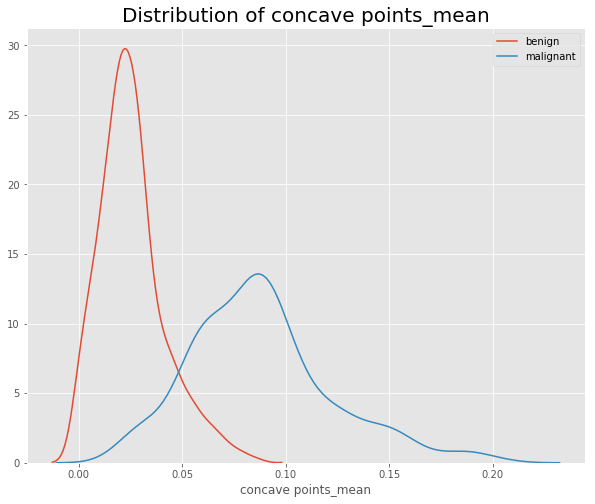

In [131]:
# Visualization
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 0, 'concave points_mean'], label = 'benign')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 1, 'concave points_mean'], label = 'malignant')

# Labeling
plt.xlabel('concave points_mean')
plt.title('Distribution of '+ 'concave points_mean', fontsize=20)

## radius_worst
- Description: "worst" or largest mean value for mean of distances from center to points on the perimeter.
- Above the median value of feature 'radius_worst', higher proportion of patients diagnosed as 'malignant' (73% vs 2%). The corresponding odds ratio is 1.6320, indicating that by increasing the value of radius_worst by one, the odds being diagnosed as 'malignant' would be 1.6320 (odds: diagnosed as 'malignant' / diagnosed as 'benign').

In [132]:
data['radius_worst'].describe()

count    569.000000
mean      16.269190
std        4.833242
min        7.930000
25%       13.010000
50%       14.970000
75%       18.790000
max       36.040000
Name: radius_worst, dtype: float64

In [133]:
print(data[data['radius_worst'] > 14.97]['diagnosis'].value_counts() / 
      sum(data[data['radius_worst'] > 14.97]['diagnosis'].value_counts()))

print(data[data['radius_worst'] <= 14.97]['diagnosis'].value_counts() / 
      sum(data[data['radius_worst'] <= 14.97]['diagnosis'].value_counts()))

1    0.727915
0    0.272085
Name: diagnosis, dtype: float64
0    0.979021
1    0.020979
Name: diagnosis, dtype: float64


Text(0.5, 1.0, 'Distribution of radius_worst')

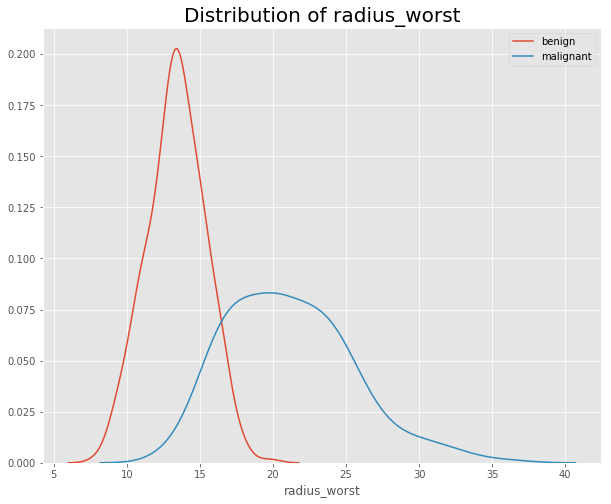

In [134]:
# Visualization
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 0, 'radius_worst'], label = 'benign')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 1, 'radius_worst'], label = 'malignant')

# Labeling
plt.xlabel('radius_worst')
plt.title('Distribution of '+ 'radius_worst', fontsize=20)

## perimeter_mean
- Description: mean size of the core tumor.
- Above the median value of feature 'perimeter_mean', higher proportion of patients diagnosed as 'malignant' (69% vs 6%). The corresponding odds ratio is 1.4108, indicating that by increasing the value of perimeter_mean by one, the odds being diagnosed as 'malignant' would be 1.4108 (odds: diagnosed as 'malignant' / diagnosed as 'benign').

In [135]:
data['perimeter_mean'].describe()

count    569.000000
mean      91.969033
std       24.298981
min       43.790000
25%       75.170000
50%       86.240000
75%      104.100000
max      188.500000
Name: perimeter_mean, dtype: float64

In [136]:
print(data[data['perimeter_mean'] > 86.24]['diagnosis'].value_counts() / 
      sum(data[data['perimeter_mean'] > 86.24]['diagnosis'].value_counts()))

print(data[data['perimeter_mean'] <= 86.24]['diagnosis'].value_counts() / 
      sum(data[data['perimeter_mean'] <= 86.24]['diagnosis'].value_counts()))

1    0.690141
0    0.309859
Name: diagnosis, dtype: float64
0    0.94386
1    0.05614
Name: diagnosis, dtype: float64


Text(0.5, 1.0, 'Distribution of perimeter_mean')

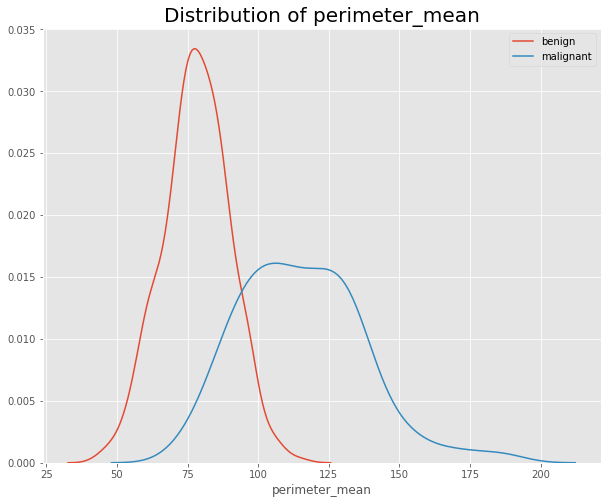

In [137]:
# Visualization
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 0, 'perimeter_mean'], label = 'benign')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 1, 'perimeter_mean'], label = 'malignant')

# Labeling
plt.xlabel('perimeter_mean')
plt.title('Distribution of '+ 'perimeter_mean', fontsize=20)

## radius_mean
- Description: mean of distances from center to points on the perimeter.
- Above the median value of feature 'radius_mean', higher proportion of patients diagnosed as 'malignant' (69% vs 6%). The corresponding odds ratio is 1.4151, indicating that by increasing the value of radius_mean by one, the odds being diagnosed as 'malignant' would be 1.4151 (odds: diagnosed as 'malignant' / diagnosed as 'benign').

In [138]:
data['radius_mean'].describe()

count    569.000000
mean      14.127292
std        3.524049
min        6.981000
25%       11.700000
50%       13.370000
75%       15.780000
max       28.110000
Name: radius_mean, dtype: float64

In [139]:
print(data[data['radius_mean'] > 13.37]['diagnosis'].value_counts() / 
      sum(data[data['radius_mean'] > 13.37]['diagnosis'].value_counts()))

print(data[data['radius_mean'] <= 13.37]['diagnosis'].value_counts() / 
      sum(data[data['radius_mean'] <= 13.37]['diagnosis'].value_counts()))

1    0.68662
0    0.31338
Name: diagnosis, dtype: float64
0    0.940351
1    0.059649
Name: diagnosis, dtype: float64


Text(0.5, 1.0, 'Distribution of radius_mean')

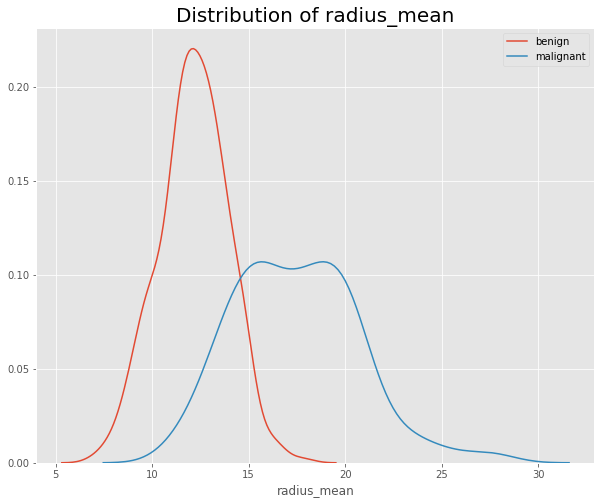

In [140]:
# Visualization
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 0, 'radius_mean'], label = 'benign')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 1, 'radius_mean'], label = 'malignant')

# Labeling
plt.xlabel('radius_mean')
plt.title('Distribution of '+ 'radius_mean', fontsize=20)

## area_worst
- Description: Not provided by the dataset. I think it might be the "worst" or largest mean size of a flat surface of a tumor.
- Above the median value of feature 'area_worst', higher proportion of patients diagnosed as 'malignant' (73% vs 2%). The corresponding odds ratio is 1.6256, indicating that by increasing the value of area_worst by one, the odds being diagnosed as 'malignant' would be 1.6256 (odds: diagnosed as 'malignant' / diagnosed as 'benign').

In [141]:
data['area_worst'].describe()

count     569.000000
mean      880.583128
std       569.356993
min       185.200000
25%       515.300000
50%       686.500000
75%      1084.000000
max      4254.000000
Name: area_worst, dtype: float64

In [142]:
print(data[data['area_worst'] > 686.50]['diagnosis'].value_counts() / 
      sum(data[data['area_worst'] > 686.50]['diagnosis'].value_counts()))

print(data[data['area_worst'] <= 686.50]['diagnosis'].value_counts() / 
      sum(data[data['area_worst'] <= 686.50]['diagnosis'].value_counts()))

1    0.725352
0    0.274648
Name: diagnosis, dtype: float64
0    0.978947
1    0.021053
Name: diagnosis, dtype: float64


Text(0.5, 1.0, 'Distribution of area_worst')

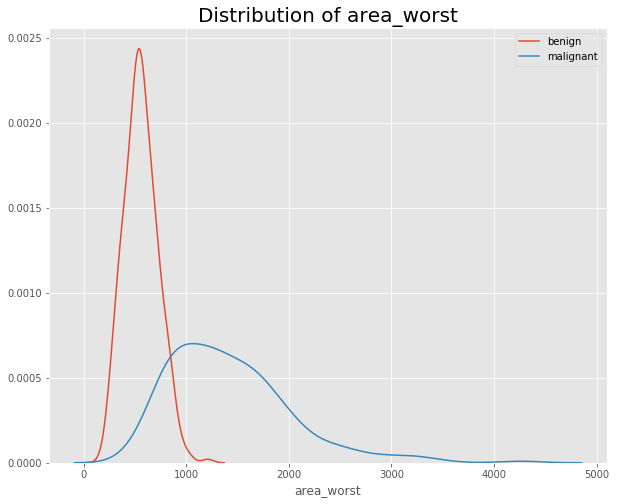

In [143]:
# Visualization
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 0, 'area_worst'], label = 'benign')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 1, 'area_worst'], label = 'malignant')

# Labeling
plt.xlabel('area_worst')
plt.title('Distribution of '+ 'area_worst', fontsize=20)

## concavity_mean
- Description: mean of severity of concave portions of the contour.
- Above the median value of feature 'concavity_mean', higher proportion of patients diagnosed as 'malignant' (70% vs 5%). The corresponding odds ratio is 1.4336, indicating that by increasing the value of concavity_mean by one, the odds being diagnosed as 'malignant' would be 1.4336 (odds: diagnosed as 'malignant' / diagnosed as 'benign').

In [144]:
data['concavity_mean'].describe()

count    569.000000
mean       0.088799
std        0.079720
min        0.000000
25%        0.029560
50%        0.061540
75%        0.130700
max        0.426800
Name: concavity_mean, dtype: float64

In [145]:
print(data[data['concavity_mean'] > 0.061540]['diagnosis'].value_counts() / 
      sum(data[data['concavity_mean'] > 0.061540]['diagnosis'].value_counts()))

print(data[data['concavity_mean'] <= 0.061540]['diagnosis'].value_counts() / 
      sum(data[data['concavity_mean'] <= 0.061540]['diagnosis'].value_counts()))

1    0.697183
0    0.302817
Name: diagnosis, dtype: float64
0    0.950877
1    0.049123
Name: diagnosis, dtype: float64


Text(0.5, 1.0, 'Distribution of concavity_mean')

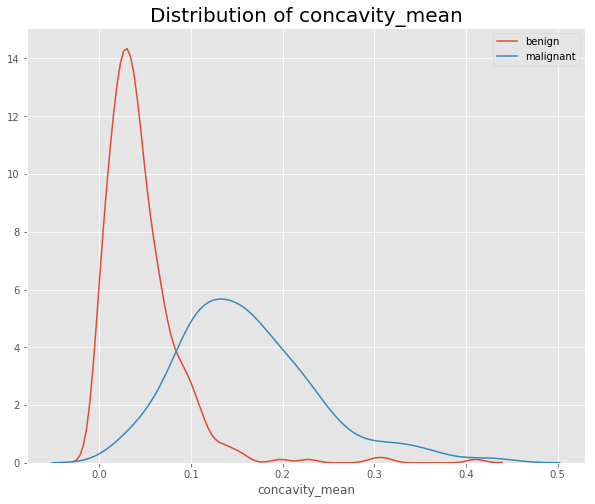

In [146]:
# Visualization
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 0, 'concavity_mean'], label = 'benign')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 1, 'concavity_mean'], label = 'malignant')

# Labeling
plt.xlabel('concavity_mean')
plt.title('Distribution of '+ 'concavity_mean', fontsize=20)

## area_mean
- Description: Not provided by the dataset. I think it might be the mean size of a flat surface of a tumor.
- Above the median value of feature 'area_mean', higher proportion of patients diagnosed as 'malignant' (69% vs 6%). The corresponding odds ratio is 1.4662, indicating that by increasing the value of area_mean by one, the odds being diagnosed as 'malignant' would be 1.4662 (odds: diagnosed as 'malignant' / diagnosed as 'benign').

In [147]:
data['area_mean'].describe()

count     569.000000
mean      654.889104
std       351.914129
min       143.500000
25%       420.300000
50%       551.100000
75%       782.700000
max      2501.000000
Name: area_mean, dtype: float64

In [148]:
print(data[data['area_mean'] > 551.10]['diagnosis'].value_counts() / 
      sum(data[data['area_mean'] > 551.10]['diagnosis'].value_counts()))

print(data[data['area_mean'] <= 551.10]['diagnosis'].value_counts() / 
      sum(data[data['area_mean'] <= 551.10]['diagnosis'].value_counts()))

1    0.68662
0    0.31338
Name: diagnosis, dtype: float64
0    0.940351
1    0.059649
Name: diagnosis, dtype: float64


Text(0.5, 1.0, 'Distribution of area_mean')

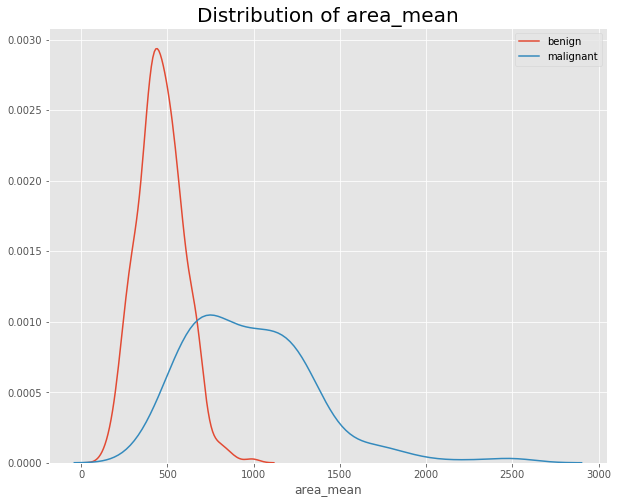

In [149]:
# Visualization
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 0, 'area_mean'], label = 'benign')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 1, 'area_mean'], label = 'malignant')

# Labeling
plt.xlabel('area_mean')
plt.title('Distribution of '+ 'area_mean', fontsize=20)

## concavity_worst
- Description: "worst" or largest mean value for severity of concave portions of the contour.
- Above the median value of feature 'concavity_worst', higher proportion of patients diagnosed as 'malignant' (70% vs 5%). The corresponding odds ratio is 1.5278, indicating that by increasing the value of concavity_worst by one, the odds being diagnosed as 'malignant' would be 1.5278 (odds: diagnosed as 'malignant' / diagnosed as 'benign').

In [150]:
data['concavity_worst'].describe()

count    569.000000
mean       0.272188
std        0.208624
min        0.000000
25%        0.114500
50%        0.226700
75%        0.382900
max        1.252000
Name: concavity_worst, dtype: float64

In [151]:
print(data[data['concavity_worst'] > 0.2267]['diagnosis'].value_counts() / 
      sum(data[data['concavity_worst'] > 0.2267]['diagnosis'].value_counts()))

print(data[data['concavity_worst'] <= 0.2267]['diagnosis'].value_counts() / 
      sum(data[data['concavity_worst'] <= 0.2267]['diagnosis'].value_counts()))

1    0.700704
0    0.299296
Name: diagnosis, dtype: float64
0    0.954386
1    0.045614
Name: diagnosis, dtype: float64


Text(0.5, 1.0, 'Distribution of concavity_worst')

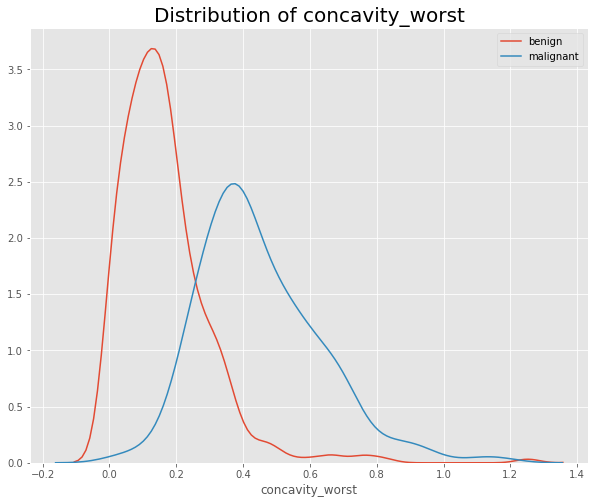

In [152]:
# Visualization
# Set the plot size
plt.figure(figsize = (10, 8))

# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 0, 'concavity_worst'], label = 'benign')
    
# KDE plot of y = 0 
sb.kdeplot(data.loc[data['diagnosis'] == 1, 'concavity_worst'], label = 'malignant')

# Labeling
plt.xlabel('concavity_worst')
plt.title('Distribution of '+ 'concavity_worst', fontsize=20)